# Sparkify Project (1/2) - Exploration

This is the data cleaning and data exploration notebook for the Sparkify Project. Sparkify is a fictional music streaming service, comparable to Spotify. In this project, a user log of approx. 12 GB is given along with a tiny subset of 128 MB. The entries contain all events created by single users, e.g. by logging in, selecting the next song, or liking a song.

Some users within this event log cancelled their subscription. The goal of this project is to predict for a given trace of user evens whether this user is likely to cancel his subscription and consequently stop to use Sparkify.

In the following notebook, the data is loaded, cleaned, explored. Based on the gained insights, in a second notebook, features are extracted and machine learning models are built and evaluated.

***Important***: This Notebook is built to be executed on an AWS EMR cluster with Spark and JupyterHub. 

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pyspark as ps
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, regexp_extract
from pyspark.sql.types import FloatType, IntegerType

import seaborn as sns

import datetime

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
10,application_1608814318362_0012,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Load and Clean Dataset
In this workspace, the full dataset file is `mini_sparkify_event_data.json`. The data is loaded and cleaned. It is checked for missing or invalid data, for example, records without userids or sessionids.

## Load the Dataset

In this example, the file is loaded from a local `.json` file.

In [2]:
# create a Spark session
#spark = SparkSession\
#        .builder\
#        .appName("Sparkify")\
#        .getOrCreate()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# load the data in spark
df_s = spark.read.json("s3n://udacity-dsnd/sparkify/sparkify_event_data.json")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
df_s.createOrReplaceTempView("df_table")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Dataset Overview

In [5]:
df_s.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [6]:
df_s.take(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042'), Row(artist='Los Bunkers', auth='Logged In', firstName='Vianney', gender='F', itemInSession=9, lastName='Miller', length=238.39302, level='paid', location='San Francisco-Oakland-Hayward, CA', method='PUT', page='NextSong', registration=1537500318000, sessionId=20836, song='MiÃ\x83Â©ntele', status=200, ts=1538352002000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1563081'), Row(artist='Lush', auth='Logged In', fi

In [7]:
df_s.describe()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [8]:
def get_unique_values(table_name, col_name):
    """
    Computes a list of unique values of the given
    table on the given column and returns a list.
    INPUT:
        table_name (str): name of the input table
        col_name (str): name of the column to search unique values
    OUTPUT:
        list (str): all unique values found
    """
    res = spark.sql("""
          SELECT DISTINCT {col_name}
          FROM {table_name}
          """.format(table_name=table_name,
                     col_name=col_name)).show()
    return res

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
# Print unique values of interesting columns
unique_query_cols = ['page', 'auth', 'level', 'gender']
for col in unique_query_cols:
    res = get_unique_values('df_table', col)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|                page|
+--------------------+
|           Downgrade|
|       Save Settings|
|               Error|
|     Add to Playlist|
|                Help|
|      Submit Upgrade|
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|         Roll Advert|
|               About|
|             Upgrade|
|Cancellation Conf...|
| Submit Registration|
|               Login|
|            Register|
|            NextSong|
|           Thumbs Up|
|              Logout|
+--------------------+
only showing top 20 rows

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
| Cancelled|
| Logged In|
+----------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------+
|gender|
+------+
|  null|
|     M|
|     F|
+------+

## Check for Missing and Invalid Data

### Check for Missing Data

First, columns with missing values are identified.

In [10]:
from pyspark.sql.functions import isnan, when, count, col
df_s.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_s.columns]).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
| artist|auth|firstName|gender|itemInSession|lastName| length|level|location|method|page|registration|sessionId|   song|status| ts|userAgent|userId|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
|5408927|   0|   778479|778479|            0|  778479|5408927|    0|  778479|     0|   0|      778479|        0|5408930|     0|  0|   778479|     0|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+

The length value is only defined for `NextSong` events. It reasonable to keep the na value for other events.

## Clean the Data

In the following section data, data columns are cleaned, invalid values are deleted and unnecessary columns are removed.

***Important***: The project contains an AWS Stepfunction called `data-pre-processing` that automates the manual steps of below "Clean the Data" and "Feature Engineering" sections.

### Clean the userAgent column

This column contains a lot details that are most likely not relevant. However, the device type / OS type could be relevant, thus we extract it.

In [11]:
# Extract the user system from column `userAgent`
df_table = spark.sql('''
  SELECT *, regexp_extract(userAgent,
                        \"\\\(([a-zA-Z 0-9.]+)\", 1)
                        as userSystem
  FROM df_table
  ''')
df_table.createOrReplaceTempView("df_table")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
df_table.head(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042', userSystem='Windows NT 6.1'), Row(artist='Los Bunkers', auth='Logged In', firstName='Vianney', gender='F', itemInSession=9, lastName='Miller', length=238.39302, level='paid', location='San Francisco-Oakland-Hayward, CA', method='PUT', page='NextSong', registration=1537500318000, sessionId=20836, song='MiÃ\x83Â©ntele', status=200, ts=1538352002000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1563081', userSystem=

In [13]:
df_table.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId', 'userSystem']

### Remove empty user names

Login events have no assigned user name. Thus, all `page = Login` events are removed.

In [14]:
df_table = spark.sql("""
                      SELECT *
                      FROM df_table
                      WHERE userId <> ''
                      """)
df_table.createOrReplaceTempView("df_table")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Delete unnecessary columns

The columns related to the name of the user, name of the listened song and the HTTP method (get/put) are deleted. The assumption is that this information does not affect the decision of a user to cancel its subscription.

In [15]:
df_s = spark.sql('''
                 SELECT userId, page, level, sessionId, ts, gender, itemInSession, userSystem, length, auth
                 FROM df_table
                 ''')
df_s.createOrReplaceTempView("df_table")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Exploratory Data Analysis

In the following, a small subset of the data is loaded and basic manipulations are done within Spark. Various statistics are evaluated on the provided data in order to derive the right features.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [16]:
"""
Define a column `churn` that is 0 before a `Cancellation Confirmation` and 1 afterwards.

Calculation logic:
- binary encoding of the events
- cumulative sum over the binary encoding
"""
# binary encoding of the 'Cancellation Confirmation' events in column churn
df_s = spark.sql('''
                  SELECT *, CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END as cancel_event
                  FROM df_table
                  ''')
df_s.createOrReplaceTempView('df_table')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
# cumulative sum over the churn column to detect phases
df_s = spark.sql('''
          SELECT *,
          SUM(cancel_event) OVER (PARTITION BY userId) as churn
          FROM df_table
          ''')
df_s.createOrReplaceTempView("df_table")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Get userId of loyal and churned users

Prepare two tables of `userId` separated by the fact whether this is a user that churned or a loyal user. This information is later needed to explore the daa based on the user group.

In [18]:
# Collect all userId of users that cancelled the subscription
cancelled_userIds = spark.sql('''SELECT userId
                                  FROM df_table
                                  GROUP BY userId
                                  HAVING MAX(churn) > 0
                          ''')
cancelled_userIds.createOrReplaceTempView("cancelled_userIds")

# print statistics
print("Overall {} users cancelled their subscription.".format(len(cancelled_userIds.collect())))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Overall 5003 users cancelled their subscription.

In [19]:
# Collect all userId of users that cancelled the subscription
loyal_userIds = spark.sql('''SELECT userId
                                  FROM df_table
                                  GROUP BY userId
                                  HAVING MAX(churn) = 0
                          ''')
loyal_userIds.createOrReplaceTempView("loyal_userIds")

# print statistics
print("Overall {} users did not cancel their subscription.".format(len(loyal_userIds.collect())))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Overall 17275 users did not cancel their subscription.

### Explore Data

After churn has been defined above, some exploratory data analysis is performed in order to observe the behaviour for users who stayed vs users who churned. The evaluation is based on building aggregates on these two groups of users in order to observe difference in their usage logs.

#### Gender of the user

In the following it is evaluated whether the gender of a user shows correlation to the churn.

In [20]:
import matplotlib.pyplot as plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

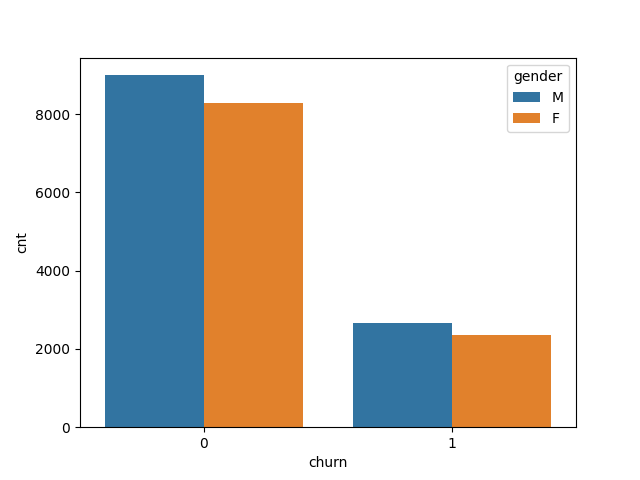

In [21]:
gender_df = spark.sql("""
          SELECT churn, gender, COUNT(gender) as cnt
          FROM (SELECT churn, userId, gender FROM df_table GROUP BY churn, userId, gender)
          GROUP BY churn, gender
          """)

sns.barplot(data=gender_df.toPandas(), x='churn', y='cnt', hue='gender')
%matplot plt

Even if it seems that the ratio of men is slightly higher among the users that churned, this could be caused by the small number of samples that actually churned.

#### Average length

The `length` event is filled out for `NextSong` and indicates the length of the played song. The listening behaviour could carry information about whether a user might `churn` or not.

In [22]:
# Extract the average length for both groups
lengths_df = spark.sql('''
          SELECT userId, churn, avg(length) as avg_len
          FROM df_table
          GROUP BY userId, churn
          ''')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

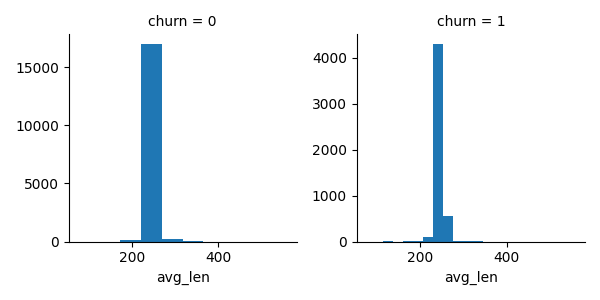

In [23]:
# visualize the distribution of length between two groups of users
g = sns.FacetGrid(lengths_df.toPandas(), col="churn", sharey=False)
g.map(plt.hist, "avg_len")
%matplot plt

Both distributions follow a different shape. Thus this feature will be included into the feature extraction process.

#### Items per session

The items per session can carry information about how intensively a user interacts with the portal and also about the session length. This could also contribute to explain the `churn`.

In [24]:
# For each user for each session, extract the average number of items to Pandas
items_per_sess_df = spark.sql('''
          SELECT churn, userId, AVG(itemInSession) as avg
          FROM df_table
          GROUP BY churn, userId
          ''')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

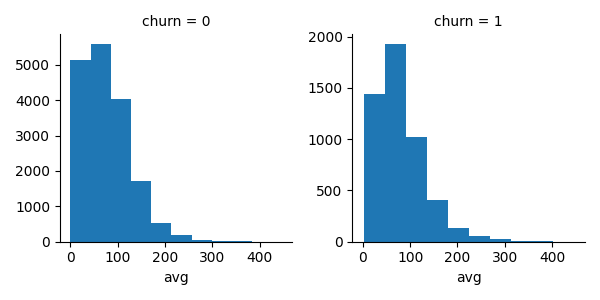

In [25]:
# visualize the distribution of length between two groups of users
g = sns.FacetGrid(items_per_sess_df.toPandas(), col="churn", sharey=False)
g.map(plt.hist, "avg")
%matplot plt

The distribution of average events is more skewed for users that churned, indicating that this feature also carries information about a potential `churn`.

#### Average sessions per day

The average sessions per day is counted by dividing the overall session count of a given user by the number of days from the first event observed until the last event observed.

In [26]:
to_days = udf(lambda x: datetime.timedelta(milliseconds=x).days, IntegerType())
spark.udf.register("to_days", to_days)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<function <lambda> at 0x7fcfb382fef0>

In [27]:
# Add the feature for average sessions per day
avg_sess_per_day = """
                   SELECT churn, userId, COUNT(DISTINCT sessionId) / (to_days(MAX(ts) - MIN(ts))+1) as avg_sess_p_day
                   FROM df_table
                   GROUP BY churn, userId
                   """
avg_sess_p_day_df = spark.sql(avg_sess_per_day)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

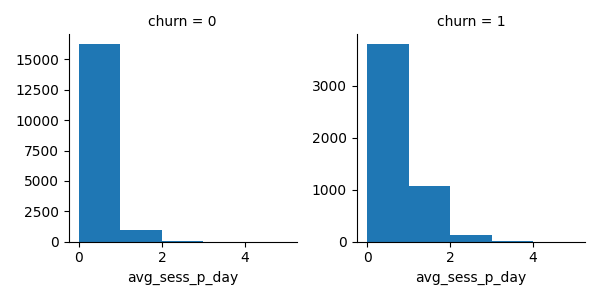

In [28]:
import numpy as np
bins = np.arange(0, 6, 1)

g = sns.FacetGrid(data=avg_sess_p_day_df.toPandas(), col="churn", sharey=False)
g.map(plt.hist, "avg_sess_p_day", bins=bins)
%matplot plt

The distribution for churned users tends to have a fatter tail. It can be assumed that this feature also contributes to the classification process.

#### Daytime of service usage

The daytime when the service is used might tell something about the potential of a user to churn. For example, users that frequently use the service in the evening might have a different churn rate than users that rather tend to use the service in the office or during lunch.

In [29]:
to_hour = udf(lambda x: float(datetime.datetime.fromtimestamp(x / 1000.0).hour), FloatType())
spark.udf.register("to_hour", to_hour)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<function <lambda> at 0x7fcfb3219f80>

In [30]:
# Add a column 'hour' to the data based on the timestamp 'ts'
hours_augmented = spark.sql('''
                   SELECT *, to_hour(ts) as hour
                   FROM df_table
                   ''')
hours_augmented.createOrReplaceTempView("df_table_hours")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
def get_bucket_percentage(table, time_col, uid_table):
    """
    Returns a Pandas DataFrame which shows for a given user group 
    the percentage of actions during time bucket in column 'col'. This function
    is used to compute the data for loyal and churned users seperately.
    INPUT:
        table (str): name of a table view that contains the 'time_col' column and a 'userId' colummn
        time_col (str): name of the time column, i.e. 'weekday' or 'hour'
        userId_list (str): name of a table that contain a column userId only.
    OUTPUT:
        Pandas DataFrame which shows the total number of events per time bucket for the given user group
    """
    res = spark.sql("""
                    SELECT {time_col}, COUNT({time_col}) / (SELECT COUNT(*) FROM {table} WHERE userId IN (SELECT * FROM {uid_table})) as count 
                    FROM {table}  
                    WHERE userId IN (SELECT * FROM {uid_table})
                    GROUP BY {time_col}
                    ORDER BY count DESC 
                    """.format(uid_table=uid_table, time_col=time_col, table=table))
    res_pd = res.toPandas()
    return res_pd

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
loyal_hours_pd = get_bucket_percentage('df_table_hours', 'hour', 'loyal_userIds')
churn_hours_pd = get_bucket_percentage('df_table_hours', 'hour', 'cancelled_userIds')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

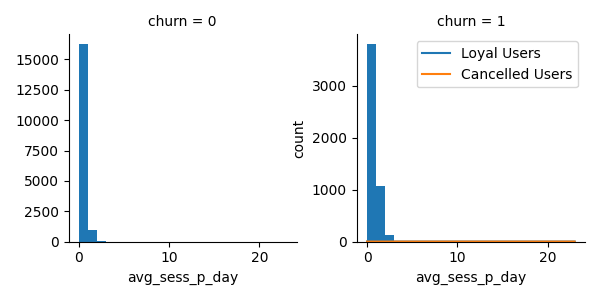

In [33]:
ax = sns.lineplot(x='hour', y='count', data=loyal_hours_pd, label='Loyal Users')
ax = sns.lineplot(x='hour', y='count', data=churn_hours_pd, label='Cancelled Users')
%matplot plt

The data shows that `loyal` users are more active during the morning hours and `cancelled` users tend to have a relatively higher activity during the afternoon.

#### Weekday of service usage

The weekday might also play a role to distinguish users that churn from loyal users. For example, users that tend to use the service during workdays might have a different probability to churn than users that use the service during the weekend.

In [34]:
to_day = udf(lambda x: float(datetime.datetime.fromtimestamp(x / 1000.0).weekday()), FloatType())
spark.udf.register("to_day", to_day)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<function <lambda> at 0x7fcfb302d830>

In [35]:
# Add a column 'weekday' to the data based on the timestamp 'ts'
weekdays_augmented = spark.sql('''
                   SELECT *, to_day(ts) as weekday
                   FROM df_table
                   ''')
weekdays_augmented.createOrReplaceTempView("df_table_weekdays")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
loyal_weekdays_pd = get_bucket_percentage('df_table_weekdays', 'weekday', 'loyal_userIds')
churn_weekdays_pd = get_bucket_percentage('df_table_weekdays', 'weekday', 'cancelled_userIds')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

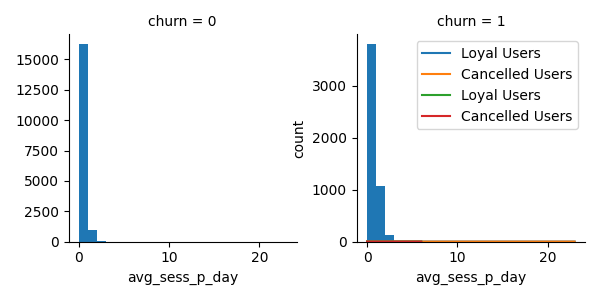

In [37]:
ax = sns.lineplot(x='weekday', y='count', data=loyal_weekdays_pd, label='Loyal Users')
ax = sns.lineplot(x='weekday', y='count', data=churn_weekdays_pd, label='Cancelled Users')
%matplot plt

The percentage of usage follows a very similar line, however, cancelled users tend to listen more on Thursday and Friday, while loyal users tend to listen more on Sunday.

#### User system distribution

The type of user agent could play a role with regards to the churn rage, for example if the experience on a smartphone device is worse than on other devices. 

In [38]:
# Compute the most frequently used system for each user
pref_user_system_tbl = spark.sql("""
                            SELECT churn, userId, MAX(userSystem) as pref_user_system
                            FROM df_table
                            GROUP BY churn, userId
                            """)
pref_user_system_tbl.createOrReplaceTempView("pref_user_system_tbl")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
# For each useer group, for each system, count the number of users
agg_user_system = spark.sql("""
                            SELECT churn, pref_user_system, 
                            COUNT(*) as cnt
                            FROM pref_user_system_tbl
                            GROUP BY churn, pref_user_system
                            """)
agg_user_system.createOrReplaceTempView("agg_user_system")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
# Normalize the user count for each system by the overall number of users in that user group
user_system_perc_df = spark.sql("""
          SELECT churn, pref_user_system, cnt / SUM(cnt) OVER (PARTITION BY churn) as percentage
          FROM agg_user_system
          """)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

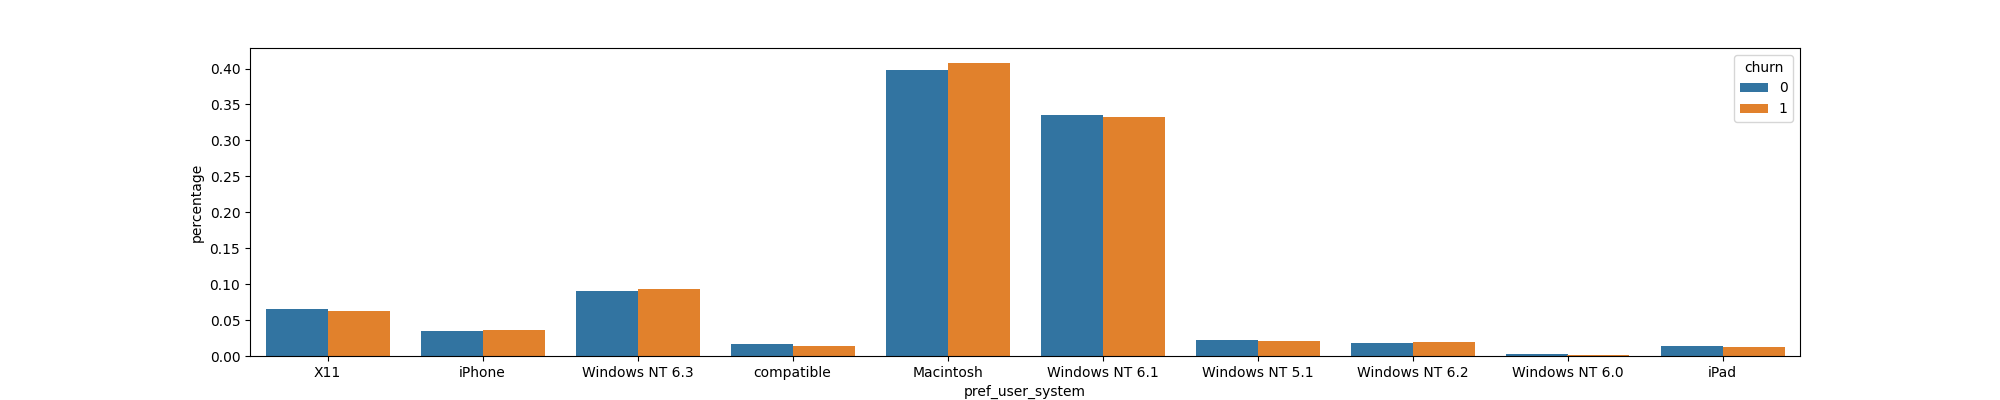

In [41]:
fig = plt.figure(figsize=(20,4))
ax = sns.barplot(x="pref_user_system", y="percentage", hue="churn", data=user_system_perc_df.toPandas())
%matplot plt

Loyal users tend to use the iPad, iPad, MacOS, Windows NT 6.1 and compatible more often than users that cancelled. Probably the user experience is better than the desktop app, or people prefer to listen to music en route.

#### Length of the trace

The length of the trace helps to undertand the data. The idea is to compare the first and last timestamp of each user.

In [42]:
# Calculate the account lifetime in days
lifetimes = spark.sql('''
                      SELECT churn, userId, to_days(MAX(ts) - MIN(ts)) as lifetime
                      FROM df_table
                      GROUP BY churn, userId
                      ''')
lifetimes.createOrReplaceTempView("lifetime_table")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Plot the distribution of account ages (account lifetime):

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

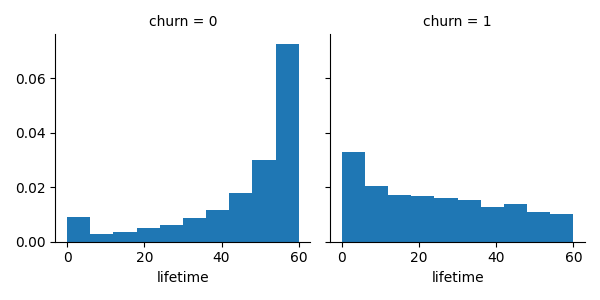

In [43]:
g = sns.FacetGrid(lifetimes.toPandas(), col='churn')
g.map(plt.hist, 'lifetime', density=True)
%matplot plt

In [44]:
agg_lifetimes = spark.sql("""
          SELECT churn,
                 AVG(lifetime) as avg,
                 MIN(lifetime) as min,
                 MAX(lifetime) as max
          FROM lifetime_table
          GROUP BY churn
          """)
agg_lifetimes.createOrReplaceTempView("agg_lifetimes")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
agg_lifetimes.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   churn        avg  min  max
0      1  23.886468    0   60
1      0  45.293372    0   60

It seems that the cancellation of accounts is uniformely distributed over the lifetime of the account. However, when an account reaches a certain age of e.g. 60 days, it might carry information whether the user will cancel the subscription.

#### Average session duration

It can be assumed that the length of a session depends on the degree of satisfaction with the music service. This is evaluated by analyzing the quartiles of the session length of both user groups.

Sessions have a unique `sessionId`. The strategy is to group by `userId` and then for each `userId`, we group by `sessionId`. Within each session group, the timedelta between the first and the last timestamp describes the session duration. This duration is converted to seconds by a `udf`.

In [46]:
to_minutes = udf(lambda x: int(datetime.timedelta(milliseconds=x).seconds/60.), IntegerType())
spark.udf.register("to_minutes", to_minutes)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<function <lambda> at 0x7fcfb31468c0>

First, the duration of each session is computed and stored in a temp view:

In [47]:
session_lengths = spark.sql('''
                              SELECT churn, userId, sessionId, to_minutes(MAX(ts)-MIN(ts)) as session_duration
                              FROM df_table
                              GROUP BY churn, userId, sessionId
                              ORDER BY userId ASC, MIN(ts) ASC
                              ''')
session_lengths.createOrReplaceTempView("session_lengths")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Based on this DataFrame, the average session duration for each user group can be analyzed:

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

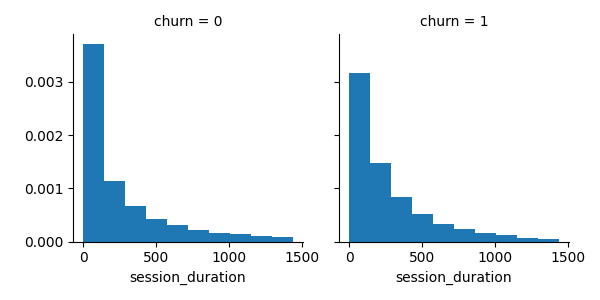

In [48]:
g = sns.FacetGrid(session_lengths.toPandas(), col='churn')
g.map(plt.hist, 'session_duration', density=True)
%matplot plt

The distribution of session duration for churned users on the smaller test data has a stronger positive skew.

Based on this, the average, minimum and maximum session length for each user is calculated:

In [49]:
agg_session_lengths = spark.sql("""
          SELECT churn, userId,
                 AVG(session_duration) as avg,
                 MIN(session_duration) as min,
                 MAX(session_duration) as max
          FROM session_lengths
          GROUP BY churn, userId
          """)
agg_session_lengths.createOrReplaceTempView("agg_session_lengths")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The data is converted to Pandas and melted, in order to be able to create a seaborn plot:

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

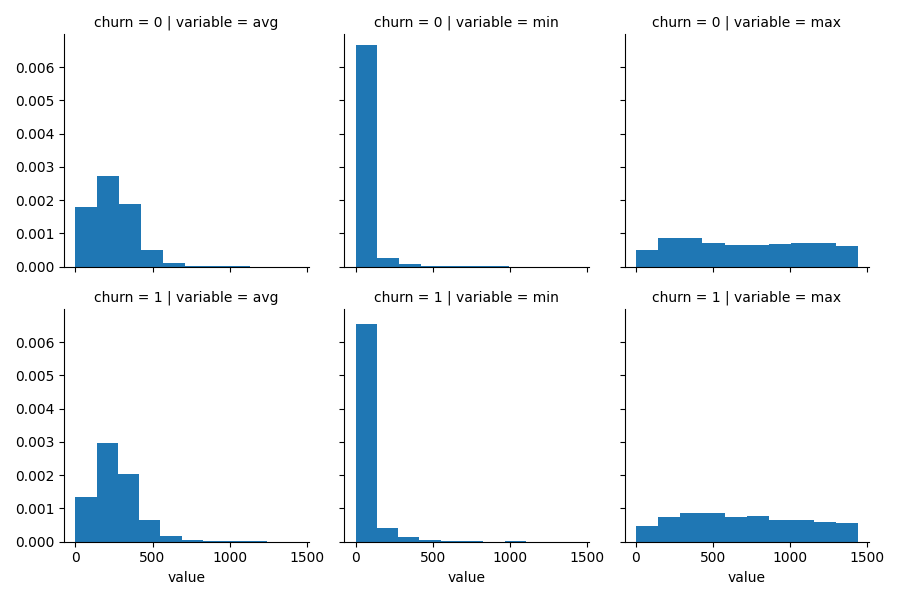

In [50]:
agg_session_lengths_pd = agg_session_lengths.toPandas()
agg_session_lengths_pd_melted = agg_session_lengths_pd.melt(id_vars=['churn', 'userId'])
g = sns.FacetGrid(agg_session_lengths_pd_melted, col='variable', row='churn')
g.map(plt.hist, 'value', density=True)
%matplot plt

The upper row shows the average, minimum and maximum session duration for loyal users. The lower row shows these values for churned users. 

The distribution of listening times shows that for 50% of the user base, the group of cancelled users tends to longer session durations. However, the 9-tile shows that loyal users seem to prefer longer listening sessions.

The n-tile distribution of the session lengths for a given user could be a relevant feature to classify the user as `churn`.

#### Payment level

Users change the payment plan over time. The up- or downgrade could give an indication about a likelihood of cancellation. For example, the downgrade to a free usage could be a first indication that the user might delete his account.

In [51]:
up_down_grades = spark.sql('''
                  SELECT *, 
                      CASE WHEN page = 'Submit Upgrade' THEN 1 ELSE 0 END as upgrade_event,
                      CASE WHEN page = 'Submit Downgrade' THEN 1 ELSE 0 END as downgrade_event
                  FROM df_table
                  ''')
up_down_grades.createOrReplaceTempView('up_down_grades')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
# cumulative sum over the churn column to detect phases
num_up_down_grades = spark.sql('''
          SELECT *,
              SUM(upgrade_event) OVER (PARTITION BY userId) as num_upgrades,
              SUM(downgrade_event) OVER (PARTITION BY userId) as num_downgrades
          FROM up_down_grades
          ''')
num_up_down_grades.createOrReplaceTempView("num_up_down_grades")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
up_downgrades_pd = spark.sql("""
                      SELECT churn, userId, 
                              MAX(num_upgrades) as num_upgrades, 
                              MAX(num_downgrades) as num_downgrades
                      FROM num_up_down_grades
                      GROUP BY churn, userId
                      """).toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
up_downgrades_pd.melt(id_vars=['churn', 'userId'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       churn   userId        variable  value
0          0  1001393    num_upgrades      1
1          0  1002143    num_upgrades      1
2          1  1002493    num_upgrades      1
3          0  1002749    num_upgrades      1
4          0  1004060    num_upgrades      1
...      ...      ...             ...    ...
44551      0  1992002  num_downgrades      0
44552      0  1992869  num_downgrades      0
44553      0  1994379  num_downgrades      0
44554      1  1995048  num_downgrades      0
44555      0  1996470  num_downgrades      1

[44556 rows x 4 columns]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

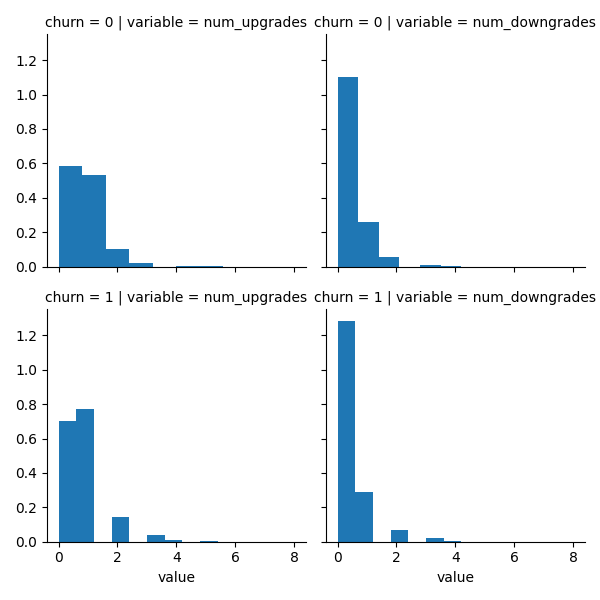

In [55]:
g = sns.FacetGrid(up_downgrades_pd.melt(id_vars=['churn', 'userId']), col='variable', row='churn')
g.map(plt.hist, 'value', density=True)
%matplot plt

The left column compares the number of upgrades for both user groups. The up- and downgrade distribution looks similar for both groups

In [56]:
cncl_payment_dist_pd = spark.sql("""
                                  SELECT churn, level, COUNT(level)
                                  FROM df_table
                                  WHERE page = 'Cancellation Confirmation'
                                  GROUP BY churn, level
                                  """).toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
cncl_payment_dist_pd

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   churn level  count(level)
0      1  paid          3424
1      1  free          1579

#### Average Click-count of pages per session

It can be assumed that loyal users tend to have a different click pattern than users that cancelled. For that, for each page, the average click count over all sessions of a given user group is calculated.

In [58]:
to_month = udf(lambda x: float(datetime.datetime.fromtimestamp(x / 1000.0).month), FloatType())
spark.udf.register("to_month", to_month)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<function <lambda> at 0x7fcfb1c683b0>

In [59]:
# Aggregate the count for each page in each session
pages_per_session = spark.sql("""
                              SELECT churn, userId, sessionId, page, COUNT(page) as cnt, to_month(AVG(ts)) as month
                              FROM df_table
                              GROUP BY churn, userId, sessionId, page
                              """)
pages_per_session.createOrReplaceTempView("pages_per_session")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
# Average page counts per user per month
tmp = spark.sql("""
          SELECT churn, userId, page, month, AVG(cnt) as avg_cnt
          FROM pages_per_session
          GROUP BY churn, userId, page, month
          """)
tmp.createOrReplaceTempView("tmp")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [61]:
# Average page counts per user over all months
tmp2 = spark.sql("""
          SELECT churn, userId, page, AVG(avg_cnt) as avg_mhly_cnt
          FROM tmp
          WHERE page <> "NextSong"
          GROUP BY churn, userId, page
          """)
tmp2.createOrReplaceTempView("tmp2")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

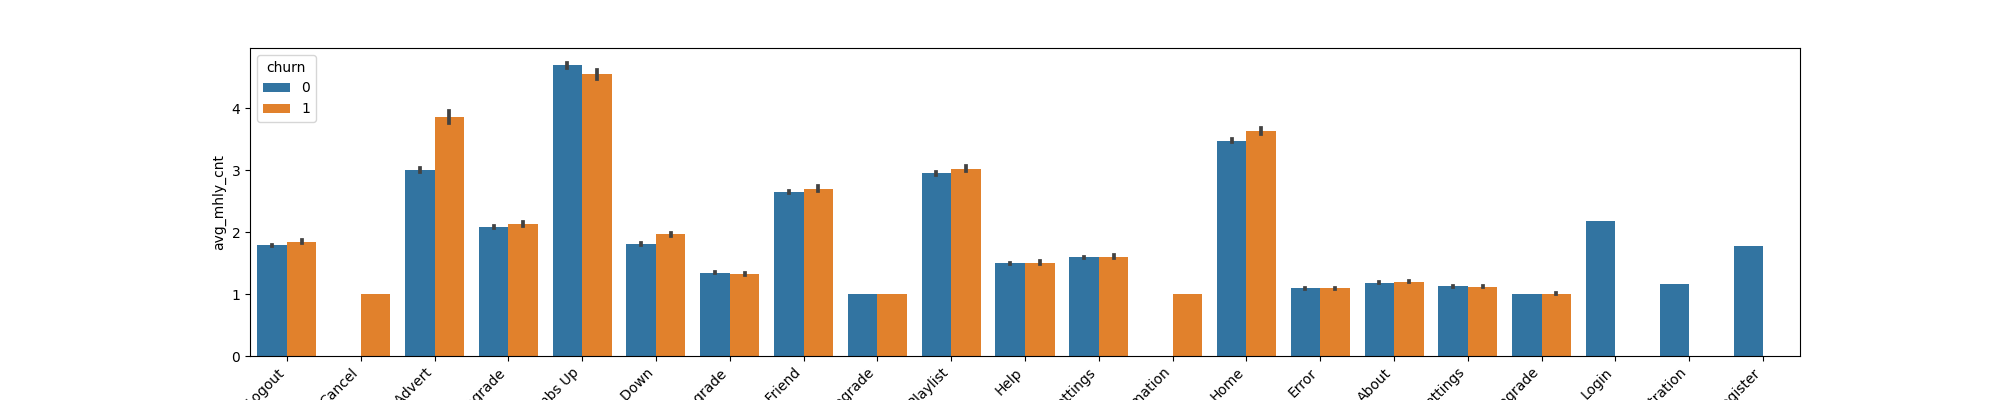

In [62]:
fig = plt.figure(figsize=(20,4))
ax = sns.barplot(x="page", y="avg_mhly_cnt", hue="churn", data=tmp2.toPandas())
plt.xticks(
    rotation=45, 
    horizontalalignment='right' 
)
%matplot plt

The average monthly click count for `NextSong` is not shown in this overview, as it is several times larger.

# Summary

This notebook first evaluated the dataset and identified necessary data cleaning steps. Next, the data was explored. Potential features were explored and visualized. This gives valuable insights for the feature engineering and the machine learning steps which will be performed in a next step.